In [1]:
import os
import glob

import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
from skimage import io
import matplotlib.pyplot as plt

import tensorflow
from tensorflow.keras import backend as K
from tensorflow.keras.models import Sequential
from tensorflow.keras import optimizers, losses, metrics
from tensorflow.keras.layers import Dense, Activation, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, TensorBoard

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay

from imgaug import augmenters as iaa


2023-03-05 22:47:27.252673: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-03-05 22:47:28.475544: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2023-03-05 22:47:28.475651: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory
2023-03-05 22:47:28.475663: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Cannot dlopen some TensorRT libraries. If you would like to use Nv

In [2]:
def compute_class_weights(df):

    # Get the frequency of each class
    class_counts = df['Label'].value_counts()
    
    # Compute the inverse frequency of each class
    inv_freq = np.max(class_counts) / class_counts
    
    # Normalize the weights to be between 0 and 1
    class_weights = inv_freq / np.sum(inv_freq)
    
    return class_weights.to_dict()

In [3]:
DATA_PATH = "/home/azureuser/cloudfiles/code/Users/jordan.pierce/Data/Guam_Saipan/3653/"
assert os.path.exists(DATA_PATH)

EXP_DIR = "Experiments/"
EXP_NAME = "Coarse_Codes_With_Weights"
EXP_FOLDER = EXP_DIR + EXP_NAME + "/"
WEIGHTS_DIR = EXP_FOLDER + "Weights/"
LOGS_DIR = EXP_FOLDER + "Logs/"

weighted = False if "No_Weights" in EXP_NAME else True

os.makedirs(EXP_DIR, exist_ok=True)
os.makedirs(EXP_FOLDER, exist_ok=True)
os.makedirs(WEIGHTS_DIR, exist_ok=True) 
os.makedirs(LOGS_DIR, exist_ok=True) 

In [4]:
coarse_classes = {
    'LC_Fol': 'Live_Coral', 
    'LC_Branch': 'Live_Coral', 
    'Ar_TA': 'Artificial', 
    'LC_Por': 'Live_Coral', 
    'UDC_CCA': 'Dead_Coral', 
    'Ro_TA': 'Rock', 
    'Pa_FA': 'Pavement', 
    'Mu_Ba': 'Mud', 
    'CR_TA': 'Coral_Rubble', 
    'Pa_Cy': 'Pavement', 
    'LC_Encr': 'Live_Coral', 
    'Sa_Ba': 'Sand', 
    'Pa_H': 'Pavement', 
    'Pa_TA': 'Pavement', 
    'UDC_H': 'Dead_Coral', 
    'CR_FA': 'Coral_Rubble', 
    'Ro_CCA': 'Rock', 
    'Mu_Cy': 'Mud', 
    'UDC_TA': 'Dead_Coral', 
    'Sa_Cy': 'Sand', 
    'UDC_FA': 'Dead_Coral', 
    'Ro_H': 'Rock', 
    'Sa_FA': 'Sand', 
    'Pa_CCA': 'Pavement', 
    'Ro_Ba': 'Rock', 
    'Ro_Cy': 'Rock', 
    'Sa_TA': 'Sand', 
    'Ar_Ba': 'Artificial', 
    'UDC_Cy': 'Dead_Coral', 
    'Ar_FA': 'Artificial', 
    'CR_CCA': 'Coral_Rubble'
}

functional_groups = {
    'LC_Fol': 'Hard_Coral', 
    'LC_Branch': 'Hard_Coral', 
    'Ar_TA': 'Algae', 
    'LC_Por': 'Hard_Coral', 
    'UDC_CCA': 'Algae', 
    'Ro_TA': 'Algae', 
    'Pa_FA': 'Algae', 
    'Mu_Ba': 'Algae', 
    'CR_TA': 'Algae', 
    'Pa_Cy': 'Other', 
    'LC_Encr': 'Hard_Coral', 
    'Sa_Ba': 'Algae', 
    'Pa_H': 'Algae', 
    'Pa_TA': 'Algae', 
    'UDC_H': 'Algae', 
    'CR_FA': 'Algae', 
    'Ro_CCA': 'Algae', 
    'Mu_Cy': 'Other', 
    'UDC_TA': 'Algae', 
    'Sa_Cy': 'Other', 
    'UDC_FA': 'Algae', 
    'Ro_H': 'Algae', 
    'Sa_FA': 'Algae', 
    'Pa_CCA': 'Algae', 
    'Ro_Ba': 'Algae', 
    'Ro_Cy': 'Other', 
    'Sa_TA': 'Algae', 
    'Ar_Ba': 'Algae', 
    'UDC_Cy': 'Other', 
    'Ar_FA': 'Algae', 
    'CR_CCA': 'Algae'
}

short_codes = [
    'LC_Fol', 
    'LC_Branch', 
    'Ar_TA', 
    'LC_Por', 
    'UDC_CCA', 
    'Ro_TA', 
    'Pa_FA', 
    'Mu_Ba', 
    'CR_TA', 
    'Pa_Cy', 
    'LC_Encr', 
    'Sa_Ba', 
    'Pa_H', 
    'Pa_TA', 
    'UDC_H', 
    'CR_FA', 
    'Ro_CCA', 
    'Mu_Cy', 
    'UDC_TA', 
    'Sa_Cy', 
    'UDC_FA', 
    'Ro_H', 
    'Sa_FA', 
    'Pa_CCA', 
    'Ro_Ba', 
    'Ro_Cy', 
    'Sa_TA', 
    'Ar_Ba', 
    'UDC_Cy', 
    'Ar_FA', 
    'CR_CCA'
]

In [5]:
data = pd.read_csv(DATA_PATH + "Updated_CNet_Annotations.csv", index_col=0)

# List of Image Names
image_names = data['Image'].unique().tolist()
print("Number Images: ", len(image_names))

if "Coarse" in EXP_NAME:
    data["Label"].replace(coarse_classes, inplace=True)
elif "Functional" in EXP_NAME:
    data["Label"].replace(functional_groups, inplace=True)
else:
    pass

# All class categories in the dataset
class_categories = data['Label'].unique()
print("Class Categories: ", len(class_categories))

# Getting a sample of each class category
sample = pd.DataFrame()

for category in class_categories:
    c = data[data['Label'] == category].sample(n=1)
    sample = pd.concat((sample, c))

Number Images:  79
Class Categories:  8


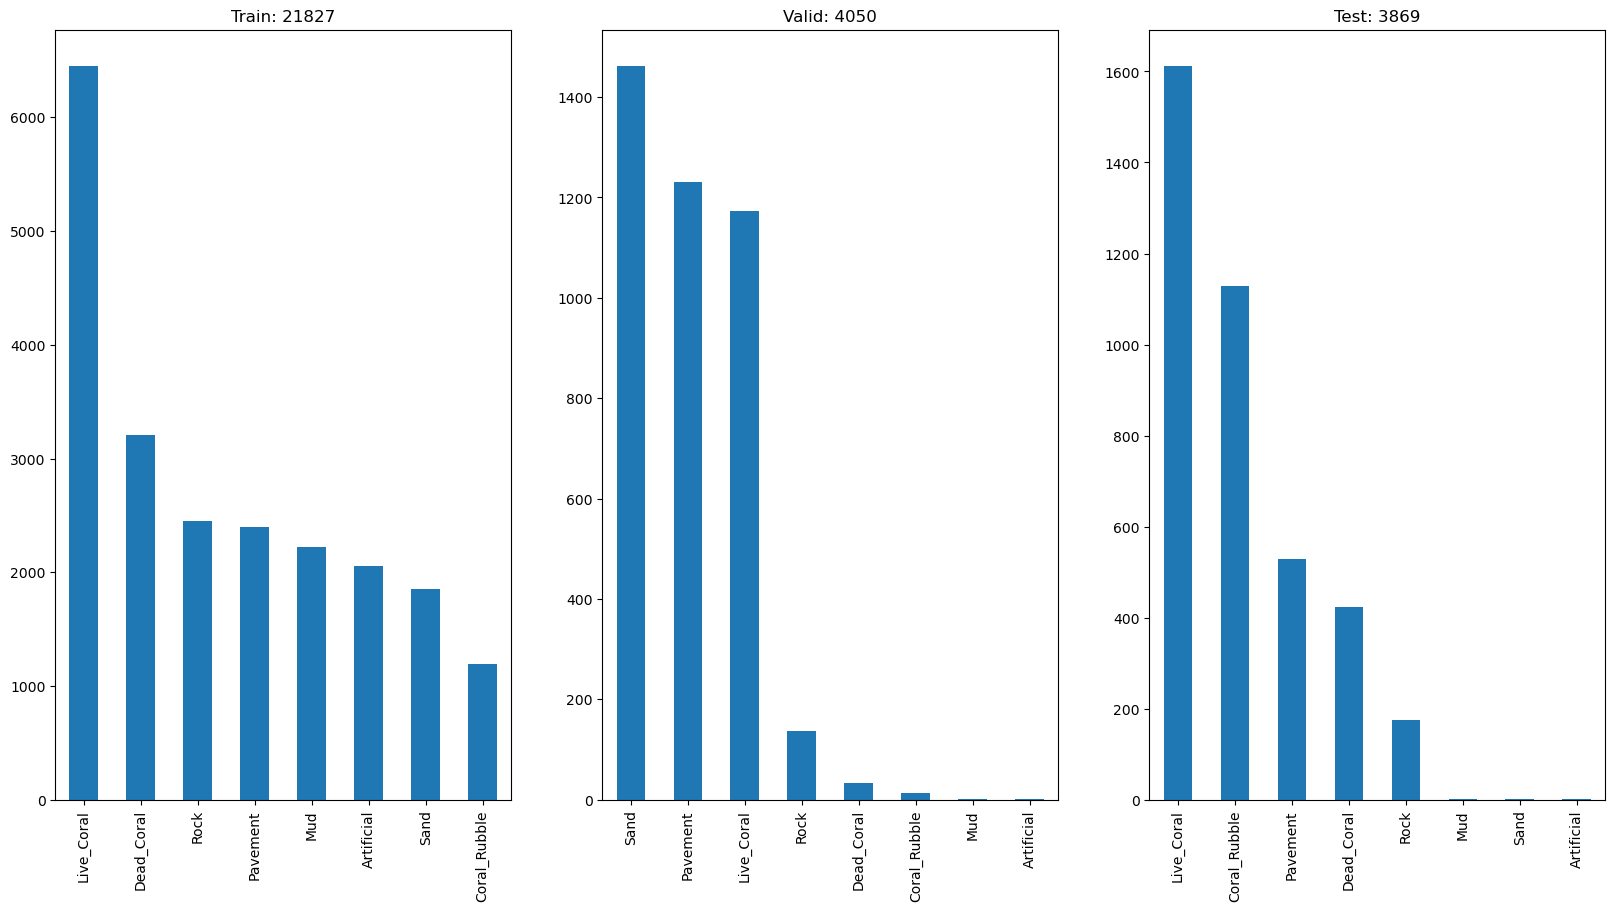

Train Class Categories:  8
Validation Class Categories:  8
Test Class Categories:  8


In [6]:
# Split the Images into training, validation, and test sets.
training_images, testing_images = train_test_split(image_names, test_size=0.1)
training_images, validation_images = train_test_split(training_images, test_size=0.2)

train = data[data['Image'].isin(training_images)]
train = pd.concat((train, sample))

valid = data[data['Image'].isin(validation_images)]
valid = pd.concat((valid, sample))

test = data[data['Image'].isin(testing_images)]
test = pd.concat((test, sample))

plt.figure(figsize=(20,10))
plt.subplot(1,3,1)
plt.title("Train: " + str(len(train)))
train['Label'].value_counts().plot(kind='bar')

plt.subplot(1,3,2)
plt.title("Valid: " + str(len(valid)))
valid['Label'].value_counts().plot(kind='bar')

plt.subplot(1,3,3)
plt.title("Test: " + str(len(test)))
test['Label'].value_counts().plot(kind='bar')
plt.savefig(EXP_FOLDER + "DatasetSplit.png")
plt.show()

# List of Class Categories
class_categories = train['Label'].unique().tolist()
print("Train Class Categories: ", len(class_categories))
print("Validation Class Categories: ", len(valid['Label'].unique().tolist()))
print("Test Class Categories: ", len(test['Label'].unique().tolist()))

In [7]:
# Augmentation methods implemented using imgaug; training augmentations should be 
# more intense, whereas the validation and testing augmentations should be minimal to none.

# Setting the amount of dropout for our model (form of data augmentation)
dropout_rate = 0.80

augs_for_train = iaa.Sequential([   
                          iaa.Resize(224, interpolation = 'linear'),
                          iaa.Fliplr(0.5),
                          iaa.Flipud(0.5),
                          iaa.Rot90([1, 2, 3, 4], True),
                          iaa.Sometimes(.3, iaa.Affine(scale = (.95, 1.05))),
                          iaa.Sometimes(.1, iaa.Invert(1.0)),
                          iaa.Sometimes(.5, iaa.SomeOf((0, 1), 
                                             [
                                                 iaa.MedianBlur(3),
                                                 iaa.ChannelShuffle(.7),
                                                 iaa.EdgeDetect(.5)
                                             ])),

                          iaa.Sometimes(.5, iaa.SomeOf((0, 1),
                                            [
                                                 iaa.Dropout(.2),
                                                 iaa.ImpulseNoise(.2),
                                                 iaa.SaltAndPepper(.2)
                                            ]))
                       ])


augs_for_valid = iaa.Sequential([iaa.Resize(224, interpolation = 'linear')])

In [8]:
# Data generators are made to take the patch file paths currently stored in the dataframes; generators
# create an augmentation pipeline so that patches can be read, augmented, and normalized on-the-fly 
# while training.

# Number of epochs to train for
num_epochs = 12

# Batch size is dependent on the amount of memory available on your machine
batch_size = 32

# Defines the length of an epoch, all images are used
steps_per_epoch_train = len(train)/batch_size
steps_per_epoch_valid = len(valid)/batch_size

# Learning rate 
lr = .0001

# Training images are augmented, and then normalized
train_augmentor = ImageDataGenerator(preprocessing_function = augs_for_train.augment_image)
                                     
                                                                   
# Reading from dataframe
train_generator = train_augmentor.flow_from_dataframe(dataframe = train, 
                                                      directory = None,
                                                      x_col = 'Patch_Name', 
                                                      y_col = 'Label', 
                                                      target_size = (224, 224), 
                                                      color_mode = "rgb",  
                                                      class_mode = 'categorical', 
                                                      batch_size = batch_size,
                                                      shuffle = True, 
                                                      seed = 42)
                                                     
# Only normalize images, no augmentation
validate_augmentor = ImageDataGenerator( preprocessing_function = augs_for_valid.augment_image)

# Reading from dataframe                             
validation_generator = validate_augmentor.flow_from_dataframe(dataframe = valid,
                                                              directory = None, 
                                                              x_col = 'Patch_Name', 
                                                              y_col = 'Label', 
                                                              target_size = (224, 224), 
                                                              color_mode = "rgb",  
                                                              class_mode = 'categorical', 
                                                              batch_size = batch_size, 
                                                              shuffle = True, 
                                                              seed = 42)

Found 21827 validated image filenames belonging to 8 classes.
Found 4050 validated image filenames belonging to 8 classes.


In [9]:
# Now we create the model!

convnet = tensorflow.keras.applications.convnext.ConvNeXtTiny(
        model_name='convnext_tiny',
        include_top=False,
        include_preprocessing=True,
        weights='imagenet',
        input_shape=(224, 224, 3),
        pooling='max',
        classes=len(class_categories),
        classifier_activation='softmax',
)

model = Sequential([
        convnet,
        Dropout(dropout_rate),
        Dense(len(class_categories)),
        Activation('softmax')
])

# Display the model architecture
if True:
    model.summary()

2023-03-05 22:54:08.710644: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-03-05 22:54:09.359733: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1613] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 10784 MB memory:  -> device: 0, name: Tesla K80, pci bus id: 0001:00:00.0, compute capability: 3.7


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 convnext_tiny (Functional)  (None, 768)               27820128  
                                                                 
 dropout (Dropout)           (None, 768)               0         
                                                                 
 dense (Dense)               (None, 8)                 6152      
                                                                 
 activation (Activation)     (None, 8)                 0         
                                                                 
Total params: 27,826,280
Trainable params: 27,826,280
Non-trainable params: 0
_________________________________________________________________


In [10]:
# Defining the Recall and Precision metric functions

def recall_m(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        recall = true_positives / (possible_positives + K.epsilon())
        return recall

def precision_m(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        return precision

In [11]:
# Defining training callbacks, such as learning rate, which will reduce after two epochs by %65 if the validation loss 
# does not decrease. Only the epochs with lower validation loss values will be saved.

callbacks = [
                 ReduceLROnPlateau(monitor = 'val_loss', factor = .65, patience = 2, verbose = 1),
                 
                 ModelCheckpoint(filepath = WEIGHTS_DIR + 'model-{epoch:03d}-{acc:03f}-{val_acc:03f}.h5', 
                                 monitor='val_loss', save_weights_only = True, save_best_only = False, verbose = 1),

            ]

In [12]:
# sets the loss function, optimizier and metrics, probably don't need to change
# except maybe the learing rate 

model.compile(loss = 'categorical_crossentropy',
              optimizer = optimizers.Adam(learning_rate=lr), 
              metrics=['acc', precision_m, recall_m])

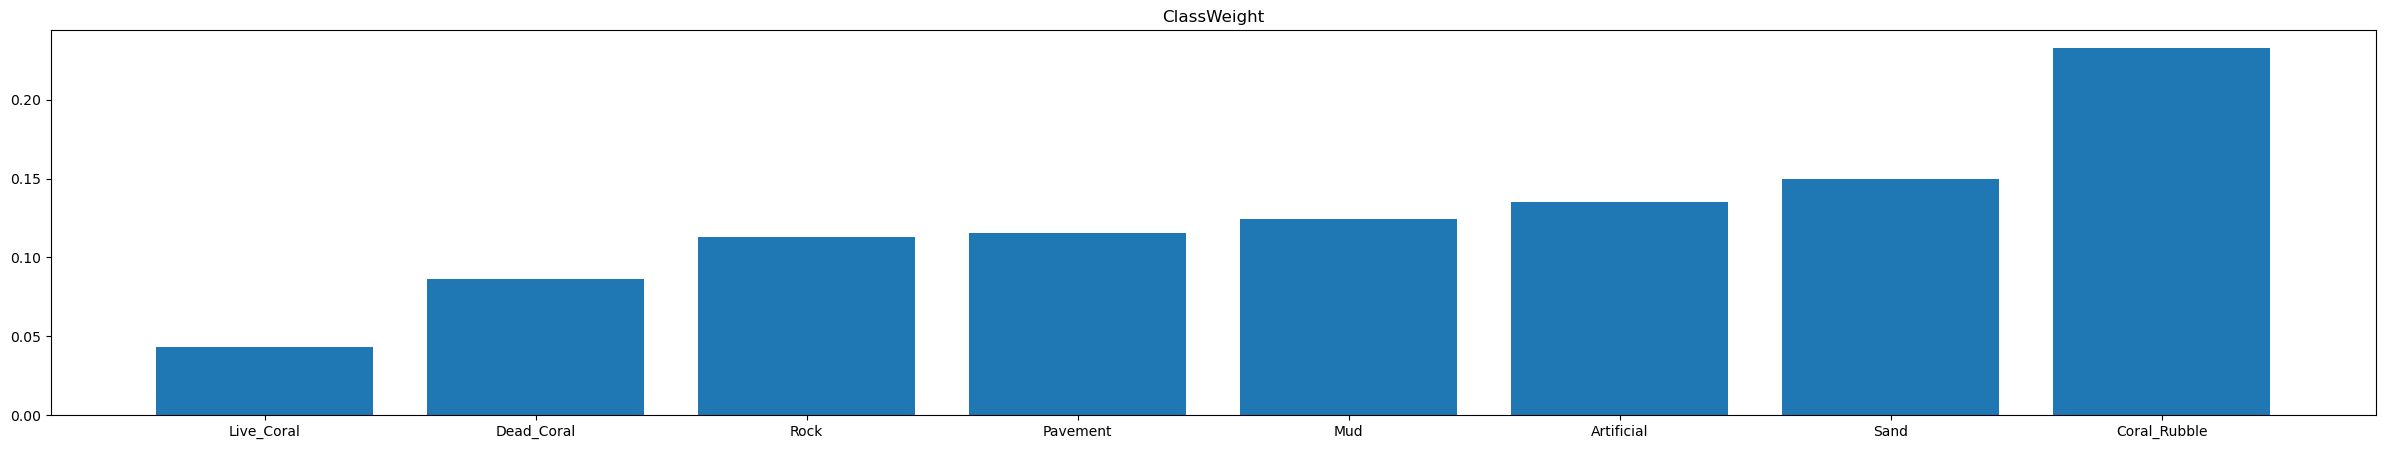

In [13]:
# Calculate the class weights, plot and save figure
if weighted:
    class_weight = compute_class_weights(train)
else:
    class_weight = {c: 1.0 for c in class_categories}

plt.figure(figsize=(30,5))
plt.bar(class_weight.keys(), class_weight.values())
plt.title("ClassWeight")
plt.savefig(EXP_FOLDER + "ClassWeight.png")
plt.show()

# Reformat for model.fit()
class_weight = {class_categories.index(k): v for (k, v) in class_weight.items()}

In [14]:
# Train the model, logs the results of the training in history

history = model.fit(train_generator, 
                    steps_per_epoch = steps_per_epoch_train, 
                    epochs = num_epochs, 
                    validation_data = validation_generator, 
                    validation_steps = steps_per_epoch_valid,
                    callbacks = callbacks,
                    verbose = 1,
                    class_weight=class_weight)  

Epoch 1/12
683/682 [==============================] - ETA: -1s - loss: 0.2226 - acc: 0.4590 - precision_m: 0.5701 - recall_m: 0.3530
Epoch 1: saving model to Experiments/Coarse_Codes_With_Weights/Weights/model-001-0.458973-0.579012.h5
682/682 [==============================] - 1291s 2s/step - loss: 0.2226 - acc: 0.4590 - precision_m: 0.5701 - recall_m: 0.3530 - val_loss: 1.8117 - val_acc: 0.5790 - val_precision_m: 0.6177 - val_recall_m: 0.4681 - lr: 1.0000e-04
Epoch 2/12
683/682 [==============================] - ETA: -1s - loss: 0.0908 - acc: 0.7511 - precision_m: 0.8320 - recall_m: 0.6853
Epoch 2: saving model to Experiments/Coarse_Codes_With_Weights/Weights/model-002-0.751088-0.594568.h5
682/682 [==============================] - 122

2023-03-05 22:54:37.671337: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:428] Loaded cuDNN version 8204
2023-03-05 22:54:37.929761: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2023-03-05 22:54:38.348832: I tensorflow/compiler/xla/service/service.cc:173] XLA service 0x18eab2c0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-03-05 22:54:38.348874: I tensorflow/compiler/xla/service/service.cc:181]   StreamExecutor device (0): Tesla K80, Compute Capability 3.7
2023-03-05 22:54:38.391154: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2023-03-05 22:54:38.595069: I tensorflow/compiler/jit/xla_compilation_cache.cc:477] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
2023-03-05 22:54:40.436293: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:2

In [ ]:
# After training, loads the best weights
weights = sorted(glob.glob(WEIGHTS_DIR + "*.h5"), key=os.path.getmtime)
[print(w, i) for i, w in enumerate(weights)];

In [ ]:
best_weights = weights[1]
print("Best Weights: ", best_weights)
model.load_weights(best_weights)

In [ ]:
# Reads from dataframe for test set
test_generator = validate_augmentor.flow_from_dataframe(dataframe = test, 
                                                        x_col = 'Patch_Name', 
                                                        y_col = 'Label', 
                                                        target_size = (224, 224), 
                                                        color_mode = "rgb",  
                                                        class_mode = 'categorical', 
                                                        batch_size = batch_size, 
                                                        shuffle = False, 
                                                        seed = 42)
# Defines the length of an epoch
steps_per_epoch_test = len(data)//1

In [ ]:
# Provides a confusion matrix of the results
# Results, stores predictions for thresholding
predictions = model.predict_generator(test_generator, steps = steps_per_epoch_test)
predict_classes = np.argmax(predictions, axis = 1)
test_y = test_generator.classes

print("# of images:", len(predict_classes))
cm = confusion_matrix(y_true = test_y, y_pred = predict_classes)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=class_categories)

overall_accuracy = accuracy_score(y_true = test_y,
                                  y_pred = predict_classes)

class_accuracy = cm.diagonal()/cm.sum(axis=1)
class_accuracy = dict(zip(class_categories, class_accuracy))

df = pd.DataFrame(list(zip(class_accuracy.keys(), class_accuracy.values())),
                  columns=['Class', 'Accuracy'])

df.to_csv(EXP_FOLDER + "ClassAccuracy.csv")

fig, ax = plt.subplots(figsize=(30, 30))
plt.title("Overall Accuracy :" + str(overall_accuracy))
disp.plot(ax=ax)
plt.savefig(EXP_FOLDER + "ConfusionMatrix.png")
print("Class Accuracy: ", df)

In [ ]:
# Higher values represents more sure/confident predictions
# .1 unsure -> .5 pretty sure -> .9 very sure

# Creating a graph of the threshold values and the accuracy
# useful for determing how sure the model is when making predictions

threshold_values = np.arange(0.0, 1.0, 0.05)
class_ACC = []

for threshold in threshold_values:
    sure_index = []

    for i in range(0, len(predictions)):
        if( (sorted(predictions[i])[-1]) - (sorted(predictions[i])[-2]) > threshold):
            sure_index.append(i)

    sure_test_y = np.take(test_y, sure_index, axis = 0)
    sure_pred_y = np.take(predict_classes, sure_index)

    class_ACC.append(accuracy_score(sure_test_y, sure_pred_y)) 

plt.figure(figsize=(10, 5))
plt.plot(threshold_values, class_ACC)
plt.xlabel('Threshold Values')
plt.xlim([0, 1])
plt.xticks(ticks = np.arange(0, 1.05, 0.1))
plt.ylabel('Classification Accuracy')
plt.title('Identifying the ideal threshold value')
plt.savefig(EXP_FOLDER + "AccuracyThreshold.png")
plt.show()

In [ ]:
model.save(WEIGHTS_DIR + "Best_Model_and_Weights.h5")